# Análise IIP

### 1 - Tratamento dos dados

In [7]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

# Configurações de estilo para os gráficos
px.defaults.template = "plotly_dark"
sns.set_style("whitegrid")


try:
    df = pd.read_csv('IIP.csv')
except FileNotFoundError:
    print("Erro")

df.head()

,COUNTRY,BOP_ACCOUNTING_ENTRY,INDICATOR,UNIT,FREQUENCY,TIME_PERIOD,value,index
0,USA,NETAL_P,NIIP,USD,Q,2005-Q4,-1.857865e+12,NaN
1,USA,NETAL_P,NIIP,USD,Q,2006-Q1,-1.655616e+12,NaN
2,USA,NETAL_P,NIIP,USD,Q,2006-Q2,-1.678770e+12,NaN
3,USA,NETAL_P,NIIP,USD,Q,2006-Q3,-2.005759e+12,NaN
4,USA,NETAL_P,NIIP,USD,Q,2006-Q4,-1.807819e+12,NaN


In [8]:
df.columns = [col.lower() for col in df.columns]
df = df.rename(columns={'bop_accounting_entry': 'accounting_entry', 'time_period': 'period'})

print("\nValores nulos por coluna:")
print(df.isnull().sum())


Valores nulos por coluna:
country                 0
accounting_entry        0
indicator               0
unit                    0
frequency               0
period                  0
value                 222
index               96247
dtype: int64


In [11]:
df.describe(exclude='number')

,country,accounting_entry,indicator,unit,frequency,period
count,96247,96247,96247,96247,96247,96247
unique,48,3,18,1,1,102
top,COL,A_P,P_MV,USD,Q,2019-Q4
freq,2739,53593,7288,96247,96247,1279


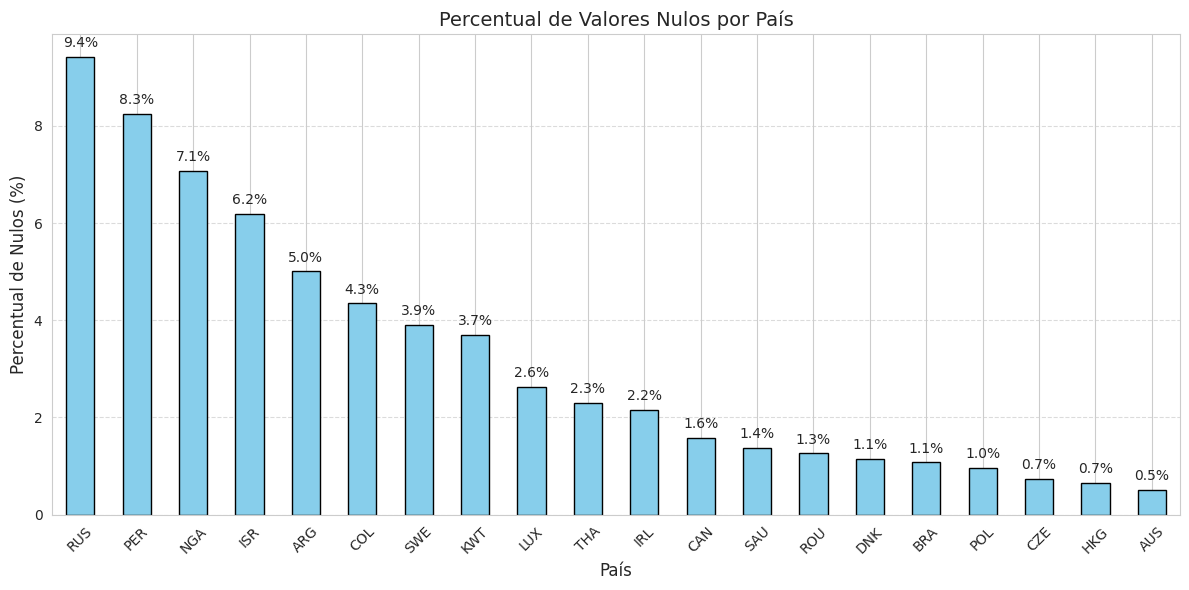

In [ ]:
import matplotlib.pyplot as plt

nulos = df.replace(0, None) # Trocando os valores zero por nulo

percentual_nulos = (
    nulos.groupby('country')['value']
    .apply(lambda x: x.isnull().mean() * 100)
    .sort_values(ascending=False)
    .head(20)
)

# Adicionando os valores no topo de cada barra
for index, value in enumerate(percentual_nulos):
    plt.text(index, value + 0.2, f'{value:.1f}%', ha='center', fontsize=10)


percentual_nulos.plot(kind='bar', figsize=(12, 6), color='skyblue', edgecolor='black')
plt.title('Percentual de Valores Nulos por País', fontsize=14)
plt.xlabel('País', fontsize=12)
plt.ylabel('Percentual de Nulos (%)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Percentual de valores nulos por país e indicador

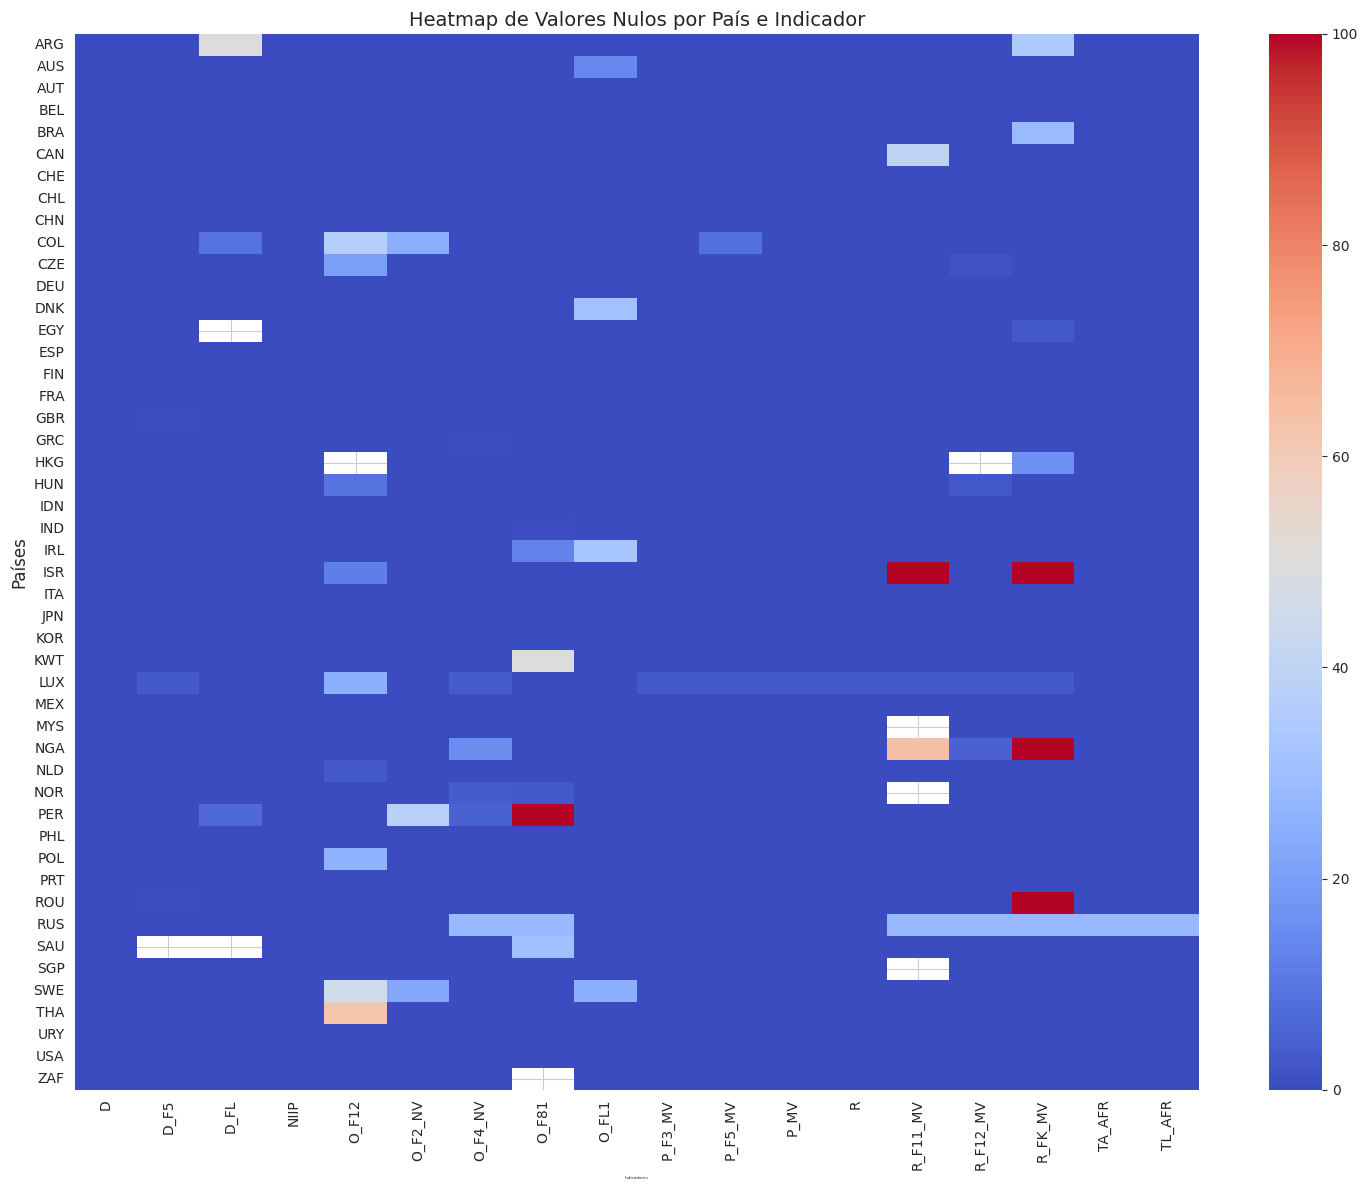

In [16]:
import numpy as np 
import seaborn as sns


percentual_nulos = (
    nulos.groupby(['country', 'indicator'])['value']
    .apply(lambda x: x.isnull().mean() * 100)
    .sort_values(ascending=False)
)
# Reshape para formato de matriz
pivot_nulos = percentual_nulos.reset_index().pivot(index='country', columns='indicator', values='value')

# Plotando o heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(pivot_nulos, cmap='coolwarm', annot=False, cbar=True)
plt.title('Heatmap de Valores Nulos por País e Indicador', fontsize=14)
plt.xlabel('Indicadores', fontsize=3)
plt.ylabel('Países', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [43]:
# Foco na Rússia
russia_nulls = df[(df['country'] == 'RUS') & (df['value'].isnull())]

russia_nulls_by_period = russia_nulls.groupby('period').size().reset_index(name='null_count')

print("Valores nulos na Rússia por período:")
print(russia_nulls_by_period)

Valores nulos na Rússia por período:
     period  null_count
0   2022-Q1           9
1   2022-Q2           9
2   2022-Q3           9
3   2022-Q4           9
4   2023-Q1           9
5   2023-Q2           9
6   2023-Q3           9
7   2023-Q4           9
8   2024-Q1           9
9   2024-Q2           9
10  2024-Q3           9
11  2024-Q4           9
12  2025-Q1           9


Nota-se que desde 2022 a Rússia não divulga mais seus dados de IIP o que justifica a ausência de dados no Dataset. Portanto, não será possível qualquer análise que envolva a Rússia no período de 2022 - 2025.

Portanto, dado que a quantidade de valores nulos nos outros países é muito pequena, opta-se pela remoção das linhas, visto que o contexto atual é apenas para uma análise prévia dos dados.

In [ ]:
df.dropna(subset=['value'], inplace=True)

#Valores em trilhões
df['value_trillions'] = df['value'] / 1e12

df_novo = df.drop('index', axis=1, inplace=True)

df.head()

,country,accounting_entry,indicator,unit,frequency,period,value,value_trillions
1,USA,NETAL_P,NIIP,USD,Q,2005-Q4,-1.857865e+12,-1.857865
2,USA,NETAL_P,NIIP,USD,Q,2006-Q1,-1.655616e+12,-1.655616
3,USA,NETAL_P,NIIP,USD,Q,2006-Q2,-1.678770e+12,-1.678770
4,USA,NETAL_P,NIIP,USD,Q,2006-Q3,-2.005759e+12,-2.005759
5,USA,NETAL_P,NIIP,USD,Q,2006-Q4,-1.807819e+12,-1.807819


In [ ]:
print(f"Países no dataset ({df['country'].nunique()})")

print(f"\nTipos de Entrada Contábil ({df['accounting_entry'].nunique()})")
#print(df['accounting_entry'].unique())

print(f"\nIndicadores no dataset ({df['indicator'].nunique()})")
# print(sorted(df['indicator'].unique()))

Países no dataset (48)

Tipos de Entrada Contábil (3)

Indicadores no dataset (18)


### 2 - Análise Global da Posição de Investimento Líquido (NIIP)

In [ ]:
# Filtrar para o indicador NIIP e o último período completo
niip_latest = df[(df['indicator'] == 'NIIP') & (df['period'] == '2025-Q1')].copy()
niip_latest.sort_values('value_trillions', inplace=True)

# Separa os 10 maiores credores e 10 maiores devedores
top_creditors = niip_latest.tail(10)
top_debtors = niip_latest.head(10)
creditors_debtors = pd.concat([top_debtors, top_creditors])

fig = px.bar(creditors_debtors,
             x='country',
             y='value_trillions',
             color='value_trillions',
             color_continuous_scale=px.colors.diverging.RdYlBu,
             color_continuous_midpoint=0,
             title='Maiores Credores e Devedores Líquidos Globais (NIIP em Trilhões de USD) - Q1 2025',
             labels={'country': 'País', 'value_trillions': 'NIIP (Trilhões de USD)'},
             text_auto='.2f')

fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

O gráfico de barras ilustra um profundo desequilíbrio no sistema financeiro global. De um lado, os Estados Unidos se destacam como o maior devedor líquido do mundo, com uma Posição Líquida de Investimento Internacional (NIIP) negativa de aproximadamente US$ 24,61 trilhões.

Do outro lado, Alemanha, China e Hong Kong emergem como os maiores credores líquidos, com posições positivas que somam trilhões de dólares. Essa polarização entre um grande centro devedor (EUA) e múltiplos centros credores (majoritariamente na Europa e Ásia) é uma característica definidora da economia global atual. Estes dados levantam o questionamento sobre como a maior potência mundial pode ser também o maior devedor líquido, e quais são as implicações dessa dinâmica para a estabilidade financeira global. Entretanto, estes resultados não significam necessariamente uma instabilidade.

https://www.stlouisfed.org/on-the-economy/2025/may/understanding-net-international-investment-position#:~:text=Recent%20research%20suggests%20that%20this,did%20not%20see%20equivalent%20gains.

##### Evolução da NIIP para os países do G7

In [ ]:
# Adiciona uma coluna para o ano
df['year'] = df['period'].str[:4]
df['year'] = pd.to_numeric(df['year'], errors='coerce')

g7_countries =['CAN', 'DEU', 'JPN', 'USA', 'ITA', 'FRA', 'GBR']
niip_trends = df[(df['indicator'] == 'NIIP') & (df['country'].isin(g7_countries))]

fig = px.line(niip_trends,
              x='year',
              y='value_trillions',
              color='country',
              title='Evolução da Posição Líquida de Investimento Internacional (NIIP) para Economias Selecionadas',
              labels={'date': 'Data', 'value_trillions': 'NIIP (Trilhões de USD)', 'country': 'País'})

fig.show()

Este gráfico mostra a dinâmica por trás dos desequilíbrios atuais. A trajetória da NIIP dos EUA (linha azul) apresenta uma deterioração constante e acelerada, (talvez essa aceleração se deve ao prejuízo da crise de 2008).

Por outro lado, Alemanha (DEU) e Japão (JPN) exibem uma tendência de acumulação estável de ativos externos, consolidando suas posições como os principais credores do mundo.

https://www.idnfinancials.com/news/54851/germany-overtakes-japan-as-worlds-largest-creditor#:~:text=However%2C%20the%20depreciation%20of%20the,(approximately%20USD%2010.51%20trillion).

### 3 - Estudo de Caso - Foco nos EUA

##### Análise de Ativos e Passivos

In [ ]:
# Filtra dados de Ativos Totais (TA_AFR) e Passivos Totais (TL_AFR) para os EUA
usa_balance_sheet = df[(df['country'] == 'USA') & (df['indicator'].isin(['TA_AFR', 'TL_AFR']))]


fig = px.line(usa_balance_sheet,
              x='year',
              y='value_trillions',
              color='indicator',
              title='Ativos e Passivos Internacionais Totais dos EUA (Trilhões de USD)',
              labels={
                  'date': 'Data',
                  'value_trillions': 'Valor (Trilhões de USD)',
                  'indicator': 'Componente',
                  'Ativos Externos Totais': 'Ativos Externos Totais',
                  'TL_AFR': 'Passivos Externos Totais'
              })

fig.update_layout(legend_title_text='Componente do Balanço')
fig.show()

O gráfico demonstra que os Estados Unidos não são apenas o maior devedor, mas também uma das nações mais globalizadas financeiramente. Tanto seus ativos (o que os EUA possuem no exterior) quanto seus passivos (o que o resto do mundo possui nos EUA) são enormes e crescentes.

A NIIP negativa resulta do fato de que seus passivos (linha vermelha) têm crescido consistentemente a uma taxa mais rápida do que seus ativos (linha azul). Isso significa que o mundo investe mais nos EUA do que os EUA investem no mundo. A questão crucial, então, é entender a natureza desses investimentos que financiam o déficit americano.

In [ ]:
indicator_map = {
    'D': 'Direct Investment', 'D_F5': 'Direct Investment',
    'P_MV': 'Portfolio Investment', 'P_F5_MV': 'Portfolio Investment', 'P_F3_MV': 'Portfolio Investment',
    'O_FL1': 'Other Investment', 'O_F2_NV': 'Other Investment', 'O_F81': 'Other Investment', 'O_F12': 'Other Investment',
    'R_F11_MV': 'Reserve Assets', 'R_FK_MV': 'Reserve Assets'
}

def map_indicator(indicator):
    for key, value in indicator_map.items():
        if key in indicator:
            return value
    return 'Uncategorized'

df['category'] = df['indicator'].apply(map_indicator)
composition_data = df[df['category']!= 'Uncategorized'].groupby(['country', 'year', 'accounting_entry', 'category'])['value_trillions'].sum().reset_index()


usa_liabilities = composition_data[(composition_data['country'] == 'USA') & (composition_data['accounting_entry'] == 'L_P')]
fig_usa = px.area(usa_liabilities, x='year', y='value_trillions', color='category',
                  title='Composição dos Passivos Externos dos EUA (Trilhões de USD)',
                  labels={'year': 'Data', 'value_trillions': 'Valor (Trilhões de USD)', 'category': 'Categoria'})
fig_usa.show()

Este gráfico de área revela como os EUA financiam sua posição devedora. A categoria predominante e de crescimento mais rápido é o Investimento em Carteira (Portfolio Investment), representada pela área verde. Isso significa que o mundo compra massivamente ativos financeiros americanos, como ações de empresas e, crucialmente, títulos de dívida do governo e de corporações.*

### 4 - Análise Comparativa

In [ ]:
g7_countries = ['CAN', 'FRA', 'GBR', 'DEU', 'ITA', 'JPN', 'USA']
latest_year_data = composition_data[(composition_data['country'].isin(g7_countries)) & (composition_data['year'] == 2025)]


total_assets = latest_year_data[latest_year_data['accounting_entry'] == 'A_P'].groupby('country')['value_trillions'].sum().rename('total_assets')
total_liabilities = latest_year_data[latest_year_data['accounting_entry'] == 'L_P'].groupby('country')['value_trillions'].sum().rename('total_liabilities')


latest_year_data = latest_year_data.merge(total_assets, on='country', how='left').merge(total_liabilities, on='country', how='left')
latest_year_data['percentage'] = np.where(
    latest_year_data['accounting_entry'] == 'A_P',
    (latest_year_data['value_trillions'] / latest_year_data['total_assets']) * 100,
    (latest_year_data['value_trillions'] / latest_year_data['total_liabilities']) * 100
)


pivot_table = latest_year_data.pivot_table(
    index='country',
    columns=['accounting_entry', 'category'],
    values='percentage'
).fillna(0)


pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns.values]
pivot_table = pivot_table.rename(columns={
    'A_P_Direct Investment': 'Ativos_% Inv. Direto', 'A_P_Portfolio Investment': 'Ativos_% Inv. Carteira',
    'A_P_Other Investment': 'Ativos_% Outros Inv.', 'A_P_Reserve Assets': 'Ativos_% Reservas',
    'L_P_Direct Investment': 'Passivos_% Inv. Direto', 'L_P_Portfolio Investment': 'Passivos_% Inv. Carteira',
    'L_P_Other Investment': 'Passivos_% Outros Inv.'
})

print("\nTabela Comparativa da Composição do Portfólio do G7 (2025, % do Total)")
display(pivot_table.style.format("{:.1f}%").background_gradient(cmap='viridis', axis=1))


Tabela Comparativa da Composição do Portfólio do G7 (2025, % do Total)


,Ativos_% Inv. Direto,Ativos_% Outros Inv.,Ativos_% Inv. Carteira,Ativos_% Reservas,Passivos_% Inv. Direto,Passivos_% Outros Inv.,Passivos_% Inv. Carteira
country,,,,,,,
CAN,44.6%,12.8%,42.5%,0.0%,42.3%,8.3%,49.4%
DEU,27.5%,30.4%,40.6%,1.4%,30.7%,17.1%,52.2%
FRA,23.7%,31.7%,43.3%,1.4%,18.6%,22.2%,59.1%
GBR,20.7%,44.1%,35.1%,0.1%,29.1%,24.5%,46.3%
ITA,22.7%,12.8%,61.1%,3.4%,24.5%,17.2%,58.3%
USA,35.4%,12.9%,50.4%,1.3%,32.2%,4.9%,62.9%


- A maioria dos países, especialmente EUA (62,9%), Itália (58,3%) e França (59,1%), possui uma grande proporção de seus passivos na forma de Investimento em Carteira.

- O Canadá (CAN) se destaca por ter uma alocação mais equilibrada entre Investimento Direto (44,6%) e Investimento em Carteira (42,5%). Já o Reino Unido (GBR) possui uma parcela alta em "Outros Investimentos" (44,1%), indicando provavelmente uma forte presença de seu setor bancário em empréstimos e depósitos internacionais.

https://en.wikipedia.org/wiki/Exorbitant_privilege